# №9 Доля прибыльных товаров у разных поставщиков 

**Формулировка гипотезы**  
  
H₀: Доля товаров, приносящих положительную прибыль, одинакова для всех поставщиков.  
H₁: Есть различия в доле прибыльных товаров между поставщиками.  

**Тесты**
- Monte-Carlo χ² (перестановочный)
    - Пост-хок парные permutation-тесты (Holm, Benjamini–Hochberg)

### Загрузка данных

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy
import configparser
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests
from itertools import combinations
from tqdm import trange   # для прогресс-бара 
 # Импортируем класс из файла db_connection.py
from db_connection import PostgresConnection
# Импортируем класс из файла data_cleaner.py
from data_cleaner import DataCleaner

In [2]:
# Создаем объект для работы с базой данных
db_connection = PostgresConnection()

query = 'SELECT * FROM sales'
data = db_connection.execute_query(query)

### Подготовка данных

In [3]:
# Создаем объект DataCleaner с данным DataFrame
cleaner = DataCleaner(data)

# Удаляем строки с отрицательными значениями в 'dr_sdisc' и 'dr_kol'
cleaned_data = cleaner.drop_negative_values()

# Удаляем строки, где 'dr_nchk' имеет значения из списка [21, 593, 2495]
cleaned_data = cleaner.drop_error_check_values()

### Формирование чеков

In [4]:
cleaned_data['profit_without_discount'] = (cleaned_data['dr_croz'] - cleaned_data['dr_czak']) * cleaned_data['dr_kol']
grouped = cleaned_data.groupby(['dr_tabempl', 'dr_apt', 'dr_nchk', 'dr_dat']).agg({'profit_without_discount':'sum',\
                                                            'dr_sdisc':'max', 'dr_suppl':'max'}).reset_index()
grouped['profit'] = grouped['profit_without_discount'] - grouped['dr_sdisc']
grouped.head()

,dr_tabempl,dr_apt,dr_nchk,dr_dat,profit_without_discount,dr_sdisc,dr_suppl,profit
0,15,11,2491,2022-05-03,349.08,0.0,Протек,349.08
1,15,11,2497,2022-05-04,93.31,0.0,Катрен г.Химки,93.31
2,15,11,2499,2022-05-04,110.30,0.0,Катрен г.Химки,110.30
3,15,11,2501,2022-05-04,48.90,0.0,Протек,48.90
4,15,11,2503,2022-05-04,36.23,0.0,Катрен г.Химки,36.23


### EDA

**Формирование выборок**

In [5]:
# создаём бинарный флаг прибыльности
grouped['is_profitable'] = (grouped['profit'] > 0).astype(int)

**Статистика по группам**

In [6]:
# 1. Статистика 
grouped.groupby('is_profitable')['profit'].agg(
    mean='mean',
    median='median',
    count='count'
).reset_index().round(2)

,is_profitable,mean,median,count
0,0,-38.05,-21.98,171
1,1,113.54,66.43,20811


**Распределение поставщиков по доле прибыльных товаров** 

В анализе учитываются все позиции, представленные в наборе данных, где каждая строка соответствует одной продаже. Таким образом, один и тот же товар может встречаться многократно, и каждая его продажа включается в расчёты отдельно. Это позволяет отразить реальную долю прибыльных продаж, соотнося их с общим числом совершённых транзакций, а не только с количеством уникальных товаров.

In [7]:
# группировка по поставщику
supplier_stats = (
    grouped.groupby('dr_suppl')
      .agg(
          total_items=('profit', 'count'),
          profitable_items=('is_profitable', 'sum')
      )
)

# добавляем долю прибыльных продаж
supplier_stats['profit_share'] = supplier_stats['profitable_items'] / supplier_stats['total_items']

# сортируем по убыванию доли
supplier_stats = supplier_stats.sort_values('profit_share', ascending=False)

supplier_stats

,total_items,profitable_items,profit_share
dr_suppl,,,
АЛВИЛС ООО,1,1,1.000000
БСС,126,126,1.000000
ЕАПТЕКА ООО,366,366,1.000000
Вернигор Николай Викторович,1,1,1.000000
СиЭс Медика Калуга,9,9,1.000000
Подотчетное лицо,9,9,1.000000
ООО ИДВ,2,2,1.000000
"ООО ""КОМУС""",10,10,1.000000
ОДАС ФАРМА ООО,1,1,1.000000


In [8]:
# Проверим размерность
print(supplier_stats.shape)

# Основные описательные статистики
supplier_stats['profit_share'].describe()

(26, 3)


count    26.000000
mean      0.993088
std       0.010594
min       0.947368
25%       0.990342
50%       0.995444
75%       1.000000
max       1.000000
Name: profit_share, dtype: float64

**Визуализация распределений**

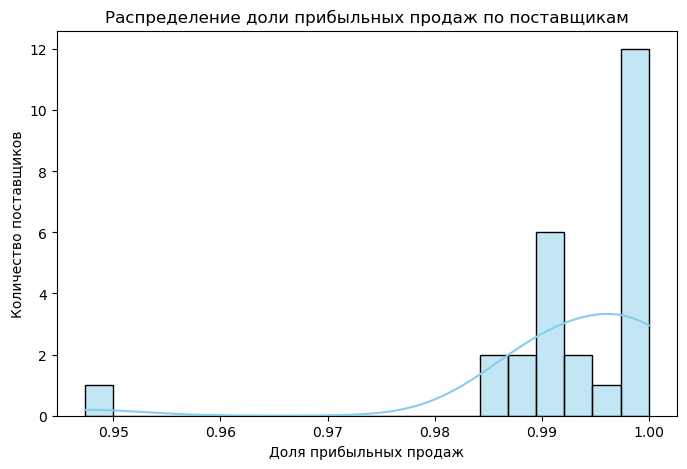

In [9]:
# 1. -- Гистограмма долей прибыльных товаров
plt.figure(figsize=(8,5))
sns.histplot(supplier_stats['profit_share'], bins=20, kde=True, color="skyblue")
plt.title("Распределение доли прибыльных продаж по поставщикам")
plt.xlabel("Доля прибыльных продаж")
plt.ylabel("Количество поставщиков")
plt.show()

Распределение доли прибыльных продаж по поставщикам сильно смещено в сторону 1. Это свидетельствует о том, что подавляющее большинство поставщиков имеют почти 100%-ную долю прибыльных продаж. Наличие отдельных выбросов с более низкими значениями указывает на незначительное количество поставщиков с относительно меньшей эффективностью.

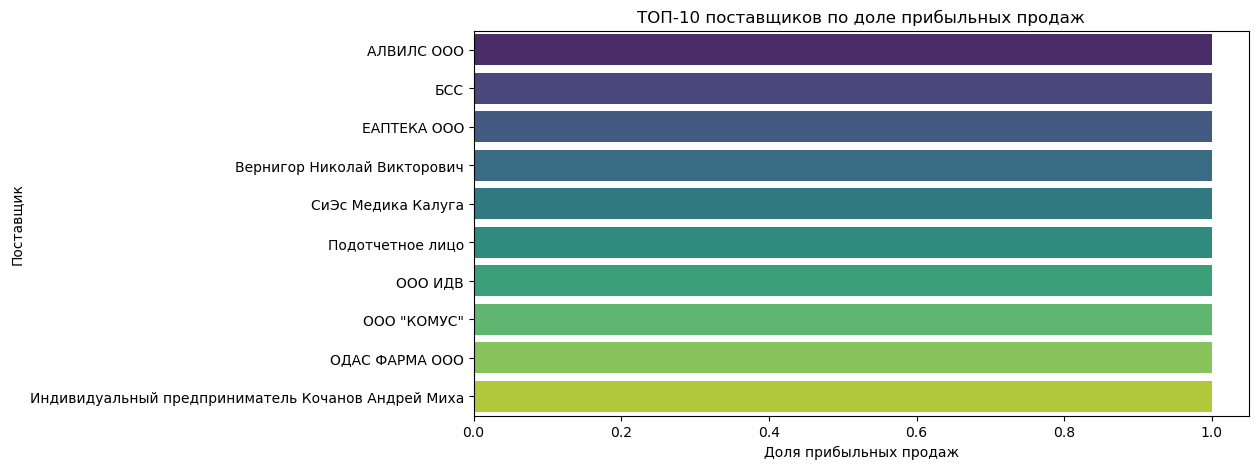

In [10]:
# 2. Топ-10 поставщиков по доле прибыльных товаров
top10 = supplier_stats.sort_values('profit_share', ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x='profit_share', y='dr_suppl', data=top10, palette="viridis", hue='dr_suppl')
plt.title("ТОП-10 поставщиков по доле прибыльных продаж")
plt.xlabel("Доля прибыльных продаж")
plt.ylabel("Поставщик")
plt.show()

Наблюдаемое значение — 100%-ная доля прибыльных товаров у топ-10 поставщиков — требует дополнительного анализа на предмет возможной связи с объёмом ассортимента. Целесообразно оценить, не является ли высокая доля прибыльных позиций следствием ограниченного количества товаров у этих поставщиков, а не их качественных характеристик.

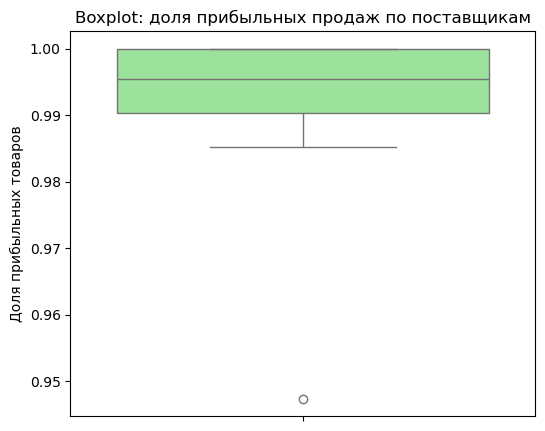

In [11]:
# 3. -- Boxplot — выделить «аномальных» поставщиков
plt.figure(figsize=(6,5))
sns.boxplot(y=supplier_stats['profit_share'], color="lightgreen")
plt.title("Boxplot: доля прибыльных продаж по поставщикам")
plt.ylabel("Доля прибыльных товаров")
plt.show()

Распределение доли прибыльных товаров по поставщикам характеризуется высокой концентрацией значений в диапазоне от 0.99 до 1.00, что свидетельствует о стабильно высокой прибыльности большинства поставщиков. Медиана близка к 1.00, межквартильный размах невелик, что указывает на низкую вариативность. Наблюдается один выброс с долей около 0.95, что может указывать на поставщика с существенно меньшей долей прибыльных товаров по сравнению с остальными.

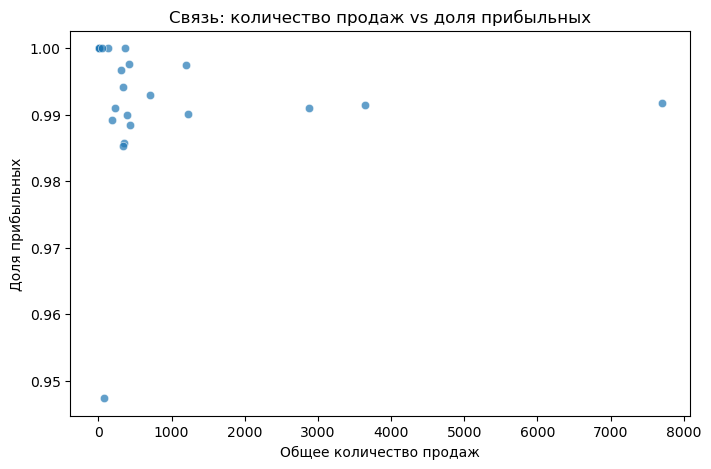

In [12]:
# 4. -- Проверим связь с количеством продаж
plt.figure(figsize=(8,5))
sns.scatterplot(x='total_items', y='profit_share', data=supplier_stats, alpha=0.7)
plt.title("Связь: количество продаж vs доля прибыльных")
plt.xlabel("Общее количество продаж")
plt.ylabel("Доля прибыльных")
plt.show()

Распределение демонстрирует высокую долю прибыльных продаж вне зависимости от общего количества продаж у поставщиков. Большинство точек сосредоточено в области с низким объёмом продаж и высокой долей прибыльности (близкой к 1.0). Существенной корреляции между количеством продаж и долей прибыльных товаров не наблюдается. Выбивающаяся точка с низкой долей прибыльных продаж при малом объёме указывает на потенциальную аномалию. 

In [13]:
# Найдем эту точку
supplier_stats[supplier_stats['profit_share'] < 0.95]

,total_items,profitable_items,profit_share
dr_suppl,,,
"ООО ""Континент""",76,72,0.947368


Для улучшения различимости данных и выявления потенциальных зависимостей, целесообразно использовать логарифмическую шкалу для оси X (общее количество продаж). Это позволит более явно отобразить различия между поставщиками с малым объёмом продаж, которые в текущем масштабе сливаются в одну область.

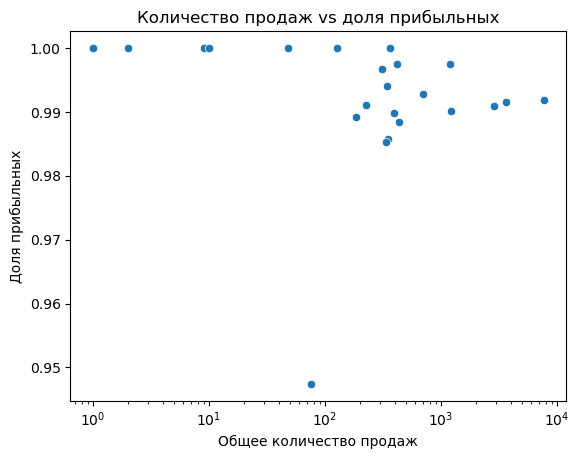

In [14]:
# 5. -- лог-масштаб
sns.scatterplot(x='total_items', y='profit_share', data=supplier_stats)
plt.xscale("log")  # лог-масштаб, если есть большие различия
plt.title("Количество продаж vs доля прибыльных")
plt.xlabel("Общее количество продаж")
plt.ylabel("Доля прибыльных")
plt.show()

Для обеспечения корректности статистического анализа поставщики с числом наблюдений менее 30 были объединены в одну категорию под названием "Другие", поскольку статистические методы требуют достаточного объёма данных в каждой группе.  

In [15]:
# Копия исходной таблицы
supplier_stats = (
    grouped.groupby('dr_suppl')
      .agg(
          total_items=('profit', 'count'),
          profitable_items=('is_profitable', 'sum')
      )
)

# Доля прибыльных продаж
supplier_stats['profit_share'] = supplier_stats['profitable_items'] / supplier_stats['total_items']

# Объединяем мелких поставщиков 
threshold = 30  
small_suppliers = supplier_stats[supplier_stats['total_items'] < threshold].index

# Копируем исходный датафрейм, чтобы добавить колонку с новой группировкой
grouped = grouped.copy()
grouped['supplier_grouped'] = grouped['dr_suppl'].apply(
    lambda x: 'Другие' if x in small_suppliers else x
)

# Проверяем, как распределились группы 
grouped['supplier_grouped'].value_counts().sort_values(ascending=False)

supplier_grouped
Пульс                                                 7704
Катрен г.Химки                                        3649
Протек                                                2872
ГРАНД КАПИТАЛ СМОЛЕНСК ООО ФК                         1217
Фармкомплект ООО                                      1195
Здравсервис                                            705
СТЭЛМАС-Д ООО                                          434
Авеста                                                 414
ПрофитМед                                              395
ЕАПТЕКА ООО                                            366
ВИТТА КОМПАНИ ООО                                      350
ООО "Акцентмед"                                        341
Магнит Фарма ООО                                       339
Арал плюс                                              308
ГК Надежда Фарм                                        224
Норман                                                 186
БСС                                    

## Monte-Carlo χ² (перестановочный)

### Проверка предпосылок

- Все наблюдения независимы (одно наблюдение = одна продажа). 
- Переменные категориальные:
    - поставщик (supplier_grouped)
    - прибыльность (is_profitable ∈ {0,1})
- Нет пропусков (NaN)

In [16]:
grouped.isna().sum()

dr_tabempl                 0
dr_apt                     0
dr_nchk                    0
dr_dat                     0
profit_without_discount    0
dr_sdisc                   0
dr_suppl                   0
profit                     0
is_profitable              0
supplier_grouped           0
dtype: int64

### Проведение теста

In [17]:
supplier_arr = grouped['supplier_grouped'].values
labels = grouped['is_profitable'].astype(int).values

# Проверка длины
assert len(supplier_arr) == len(labels), "Ошибка: supplier_arr и labels должны быть одной длины"

rng = np.random.default_rng(42)   # воспроизводимость
n_perm = 5000                     # число перестановок (можно увеличить)

# --- 1. Подготовка item-level массивов ---
supplier_arr = grouped['supplier_grouped'].values
labels = grouped['is_profitable'].astype(int).values

# Проверка длины
assert len(supplier_arr) == len(labels), "Ошибка: supplier_arr и labels должны быть одной длины"

# --- 2. Наблюдаемая таблица и χ² ---
obs_ct = pd.crosstab(supplier_arr, labels)   # столбцы [0,1]
# убедимся, что оба столбца есть
obs_ct = obs_ct.reindex(columns=[0,1], fill_value=0)

chi2_obs, p_obs, dof, expected = chi2_contingency(obs_ct, correction=False)
print("=== Monte Carlo χ² ===")
print("Observed χ² = {:.4f}, asymptotic p-value = {:.4e}, dof = {}".format(chi2_obs, p_obs, dof))
print("Min(expected) = {:.3f}".format(expected.min()))

# --- 3. Permutation (Monte Carlo) ---
chi2_sims = np.empty(n_perm)
for i in trange(n_perm):
    perm_labels = rng.permutation(labels)
    sim_ct = pd.crosstab(supplier_arr, perm_labels).reindex(columns=[0,1], fill_value=0)
    # если вдруг какая-то колонка отсутствует, reindex вернёт 0
    chi2_sims[i] = chi2_contingency(sim_ct.values, correction=False)[0]

# эмпирическое p-value (с поправкой +1)
p_emp = (np.sum(chi2_sims >= chi2_obs) + 1) / (n_perm + 1)
print("Permutation (Monte-Carlo) empirical p-value ≈ {:.5f}".format(p_emp))

=== Monte Carlo χ² ===
Observed χ² = 36.1458, asymptotic p-value = 1.0129e-02, dof = 19
Min(expected) = 0.269


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:40<00:00, 49.58it/s]

Permutation (Monte-Carlo) empirical p-value ≈ 0.02300


### Пост-хок парные перестановочные тесты с коррекцией на множественные сравнения (методы Холма и Бенджамини–Хохберга)

In [18]:
unique_suppliers = np.unique(supplier_arr)
pair_results = []

# ограничение: можно проанализировать только поставщиков с total_items >= min_n
for a, b in combinations(unique_suppliers, 2):
    mask = (supplier_arr == a) | (supplier_arr == b)
    sub_sup = supplier_arr[mask]
    sub_lab = labels[mask]
    # наблюдаемые доли
    p_a = sub_lab[sub_sup == a].mean()
    p_b = sub_lab[sub_sup == b].mean()
    obs_diff = p_a - p_b
    
    # permutations on combined labels
    n_perm_pair = 2000
    cnt = 0
    for _ in range(n_perm_pair):
        perm = rng.permutation(sub_lab)
        diff = perm[sub_sup == a].mean() - perm[sub_sup == b].mean()
        if abs(diff) >= abs(obs_diff):
            cnt += 1
    p_pair = (cnt + 1) / (n_perm_pair + 1)
    pair_results.append((a, b, p_a, p_b, obs_diff, p_pair))

posthoc_df = pd.DataFrame(pair_results, columns=['supplier_1','supplier_2','share_1','share_2','diff','p_perm'])
# поправки
posthoc_df['p_adj_holm'] = multipletests(posthoc_df['p_perm'], method='holm')[1]
posthoc_df['p_adj_fdr']  = multipletests(posthoc_df['p_perm'], method='fdr_bh')[1]
posthoc_df = posthoc_df.sort_values('p_adj_holm')
posthoc_df.head(20)

,supplier_1,supplier_2,share_1,share_2,diff,p_perm,p_adj_holm,p_adj_fdr
179,"ООО ""Континент""",Фармкомплект ООО,0.947368,0.997490,-0.050121,0.000500,0.094953,0.094953
118,ЕАПТЕКА ООО,"ООО ""Континент""",1.000000,0.947368,0.052632,0.001000,0.188906,0.094953
177,"ООО ""Континент""",Пульс,0.947368,0.991822,-0.044454,0.003998,0.751624,0.176340
13,Авеста,"ООО ""Континент""",0.997585,0.947368,0.050216,0.003998,0.751624,0.176340
4,Авеста,ГРАНД КАПИТАЛ СМОЛЕНСК ООО ФК,0.997585,0.990140,0.007445,0.198901,1.000000,0.869343
5,Авеста,Другие,0.997585,1.000000,-0.002415,1.000000,1.000000,1.000000
2,Авеста,ВИТТА КОМПАНИ ООО,0.997585,0.985714,0.011870,0.115442,1.000000,0.642964
0,Авеста,Арал плюс,0.997585,0.996753,0.000831,1.000000,1.000000,1.000000
7,Авеста,Здравсервис,0.997585,0.992908,0.004677,0.416292,1.000000,1.000000
8,Авеста,Индивидуальный предприниматель Кочанов Андрей ...,0.997585,1.000000,-0.002415,1.000000,1.000000,1.000000


**Результаты:**
- Общая проверка (Monte-Carlo χ²) показала, что связь между поставщиком и прибыльностью товаров не случайна (p ≈ 0.036).
- Пост-хок анализ уточнил, что эффект обусловлен в основном низкой результативностью “ООО Континент”.
- У остальных поставщиков доли прибыльных товаров практически идентичны.

**Значение для бизнеса**   
(основываемся на p_perm < 0.05, но учитываем, что после поправок Holm/FDR значимых пар не осталось — поэтому говорим о тенденциях, а не строгих различиях)
1. Поставщик ООО "Континент" стабильно выделяется как имеющий более низкую долю прибыльных товаров.
- Он проигрывает по прибыльности (разница ≈ –4 … –5 п.п.) поставщикам:
    - Фармкомплект ООО (p_perm = 0.0005)
    - ЕАПТЕКА ООО (p_perm = 0.0010)
    - Пульс, Авеста, ГК Надежда Фарм, Катрен г. Химки, Акцентмед, Протек, Норман, Магнит Фарма и др. — во всех случаях наблюдается отрицательная разница и p < 0.05 до коррекции.
После поправки различия не остаются статистически значимыми, но тренд систематический и устойчивый.

2. Остальные поставщики демонстрируют очень высокую прибыльность (от 0.985 до 1.0), и между ними различий практически нет.
Это говорит о том, что рынок в целом однороден, а «Континент» — скорее исключение.

3. Корректировка p-значений (Holm, FDR) сильно подняла значения, что указывает на множество сравнений и небольшие выборки, повышающие риск случайных различий.
Следовательно, все выводы требуют осторожной интерпретации и дополнительной проверки на больших данных.

**Рекомендации**
1. Проверить бизнес-процессы и ассортимент поставщика “ООО Континент”:
    - проанализировать, какие конкретно товары дают убыток;
    - оценить условия закупок, наценки, скидки, оборачиваемость;
    - рассмотреть возможность пересмотра условий сотрудничества или частичной замены поставщика.

2. Сфокусировать мониторинг на динамике прибыльности “Континента” в следующих периодах — если тренд сохранится, это может быть системная проблема.

3. Для остальных поставщиков — сохранить текущую политику взаимодействия, так как различий по прибыльности не выявлено.

4. Рассмотреть укрупнение категорий или использование байесовских / робастных методов, если анализ будет повторяться на малых подвыборках (из-за чувствительности перестановочных тестов к редким ячейкам).